# Demand forecasting with the Temporal Fusion Transformer

Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [3]:
from google.cloud import aiplatform

## Load data

First, we need to transform our time series into a pandas dataframe where each row can be identified with a time step and a time series. Fortunately, most datasets are already in this format. For this tutorial, we will use the [Stallion dataset from Kaggle](https://www.kaggle.com/utathya/future-volume-prediction) describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step. Further, it is beneficial to add date features, which in this case means extracting the month from the date record.

In [4]:
project_id = 'pytorch-tpu-nfs'
dataset_id = 'view_dataset'
table_id = 'weather_time_series_named'
location = 'us-central1'
staging_bucket = 'automl-samples'
experiment_prefix = 'pytorch-forecasting'

In [5]:
from datetime import datetime

# Create and experiment tag
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
experiment_id = f"{experiment_prefix}-{TIMESTAMP}"

In [6]:
experiment_id

'pytorch-forecasting-20211110232440'

In [7]:
# Init AI Platform
aiplatform.init(
    project=project_id,
    staging_bucket=staging_bucket,
    experiment=experiment_id
)

INFO:root:Resource pytorch-forecasting-20211110232440 not found.
INFO:root:Creating Resource pytorch-forecasting-20211110232440


In [8]:
run_id = f"learning-rate-search"
aiplatform.start_run(run=run_id)

INFO:root:Resource pytorch-forecasting-20211110232440-learning-rate-search not found.
INFO:root:Creating Resource pytorch-forecasting-20211110232440-learning-rate-search
INFO:root:Resource pytorch-forecasting-20211110232440-learning-rate-search-metrics not found.
INFO:root:Creating Resource pytorch-forecasting-20211110232440-learning-rate-search-metrics


In [9]:
from google.cloud import bigquery

sql = f"""
SELECT *
FROM  `{project_id}.{dataset_id}.{table_id}`
LIMIT 10000
"""
client = bigquery.Client(location=location, project=project_id)
query_job = client.query(
  sql,
  # Location must match that of the dataset(s) referenced in the query.
  location=location,
)  # API request - starts the query

data = query_job.to_dataframe()


In [10]:
# add time index

data["time_idx"] =  data["Date_Time"].dt.year*365*24 + data["Date_Time"].dt.dayofyear * 24 + data["Date_Time"].dt.hour
#data["time_idx"] =  data["Date_Time"].dt.hour
       
data["time_idx"] -= data["time_idx"].min()

data.head(10)

,series,Date_Time,p__mbar,T__degC,Tpot__K,Tdew__degC,rh__percent,VPmax__mbar,VPact__mbar,VPdef__mbar,sh__g_per_kg,H2OC__mmol_per_mol,rho__gm_per_cubic_m,wv__m_per_s,max_w__vm_per_s,wd__deg,time_idx
0,Temp,2009-01-01 04:00:00+00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00,3
1,Temp,2009-01-05 11:00:00+00:00,989.97,-3.53,270.41,-5.11,88.7,4.70,4.17,0.53,2.63,4.21,1276.99,5.06,7.88,13.74,106
2,Temp,2009-01-05 12:00:00+00:00,990.42,-3.65,270.26,-5.54,86.6,4.66,4.04,0.62,2.54,4.08,1278.21,5.49,8.38,17.44,107
3,Temp,2009-01-05 13:00:00+00:00,990.82,-4.15,269.72,-5.84,87.9,4.49,3.94,0.54,2.48,3.98,1281.16,5.91,9.75,28.54,108
4,Temp,2009-01-05 14:00:00+00:00,991.08,-4.57,269.28,-6.05,89.3,4.35,3.88,0.47,2.44,3.92,1283.50,6.11,7.75,19.12,109
5,Temp,2009-01-05 15:00:00+00:00,991.80,-5.14,268.66,-6.54,89.8,4.16,3.74,0.42,2.35,3.77,1287.24,5.67,8.25,26.38,110
6,Temp,2009-01-05 16:00:00+00:00,992.67,-5.74,267.99,-7.36,88.2,3.98,3.51,0.47,2.20,3.53,1291.37,7.11,9.50,31.28,111
7,Temp,2009-01-05 17:00:00+00:00,993.40,-6.38,267.29,-7.95,88.5,3.79,3.35,0.44,2.10,3.37,1295.53,7.23,9.50,20.77,112
8,Temp,2009-01-05 18:00:00+00:00,994.25,-6.85,266.75,-8.55,87.6,3.65,3.20,0.45,2.00,3.22,1299.00,6.34,9.25,20.57,113
9,Temp,2009-01-05 19:00:00+00:00,994.69,-7.90,265.66,-11.46,75.4,3.36,2.54,0.83,1.59,2.55,1305.05,7.29,10.38,20.94,114


### Create dataset and dataloaders

In [11]:
pl.seed_everything(42)
max_prediction_length = 24
max_encoder_length = 120
training_cutoff = data["time_idx"].max() - 100*max_prediction_length

time_varying_known_reals = [
    'p__mbar',
    'Tpot__K',
    'Tdew__degC',
    'rh__percent',
    'VPmax__mbar',
    'VPact__mbar',
    'VPdef__mbar',
    'sh__g_per_kg',
    'H2OC__mmol_per_mol',
    'rho__gm_per_cubic_m',
    'wv__m_per_s',
    'max_w__vm_per_s',
    'wd__deg',
    'time_idx'
]
    
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="T__degC",
    #categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["T__degC"],
    time_varying_known_reals=time_varying_known_reals,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet(
    data[lambda x: x.time_idx > training_cutoff],
    time_idx="time_idx",
    target="T__degC",
    #categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["T__degC"],
    time_varying_known_reals=time_varying_known_reals,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(validation, data, predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

Global seed set to 42


## Create baseline model

In [12]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
[~torch.any(baseline_predictions.isnan(), dim=1)]
diff = (actuals - baseline_predictions)
diff = diff[~torch.any(diff.isnan(), dim=1)].abs().mean().item()
diff

2.2035977840423584

In [13]:
aiplatform.log_metrics({"baseline-mae": diff})

## Train the Temporal Fusion Transformer

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).

In [14]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 38.7k


In [15]:
aiplatform.log_metrics({"tft-params": tft.size()})

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:818: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 304   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_sel

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_MAE': 3.1428749561309814,
 'val_MAPE': 2691175.0,
 'val_RMSE': 3.771014451980591,
 'val_SMAPE': 0.9499929547309875,
 'val_loss': 1.245483160018921}
--------------------------------------------------------------------------------


Restoring states from the checkpoint file at /home/jupyter/ml-ops-patterns/view_demo/research/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/jupyter/ml-ops-patterns/view_demo/research/lr_find_temp_model.ckpt


suggested learning rate: 0.07943282347242808


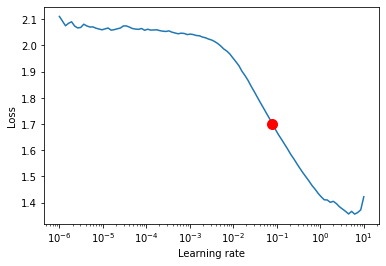

In [16]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [17]:
aiplatform.log_metrics({"Suggested-lr": res.suggestion()})

### Train model

If you have troubles training the model and get an error ```AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'```, consider either uninstalling tensorflow or first execute

```
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.

In [18]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=1,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 38.7k


Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [19]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 304   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_select

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Hyperparameter tuning

In [20]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [21]:
# print(study.best_trial.params)

## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [27]:
torch.save(best_tft, 'sample.pt')

In [28]:
m = torch.load('sample.pt')

In [35]:
for i in val_dataloader:
    #print(i)
    print(i[0].keys())
    #o = m.predict(i)
    break

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


In [35]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
diff = (actuals - predictions)
diff = diff[~torch.any(diff.isnan(), dim=1)].abs().mean().item()
diff
#(actuals - predictions).abs().mean()

0.973061740398407

In [22]:
aiplatform.log_metrics({"training-mae": diff})

In [36]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

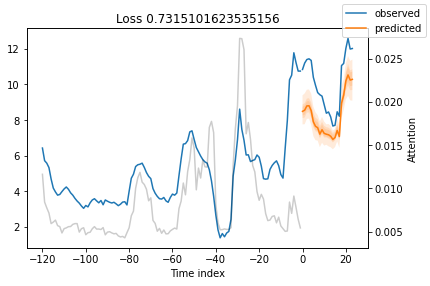

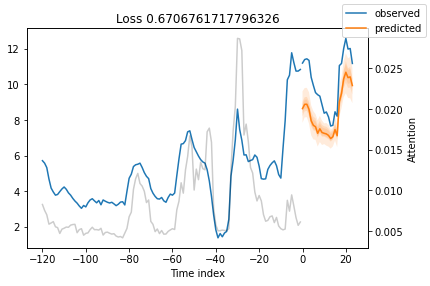

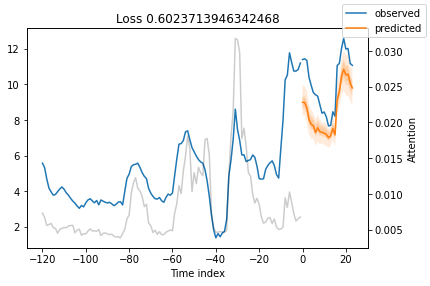

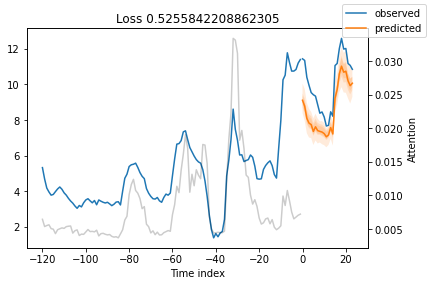

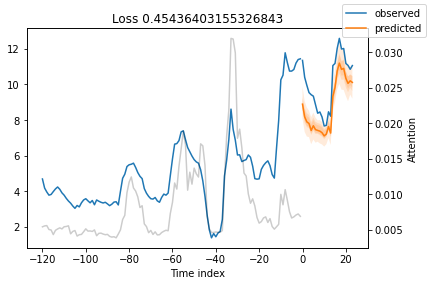

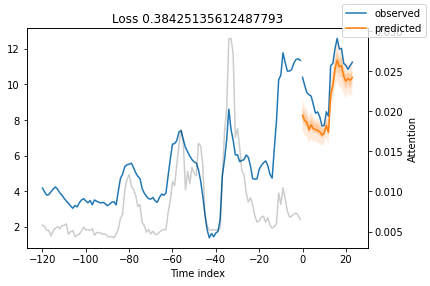

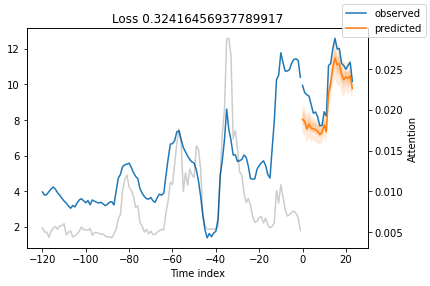

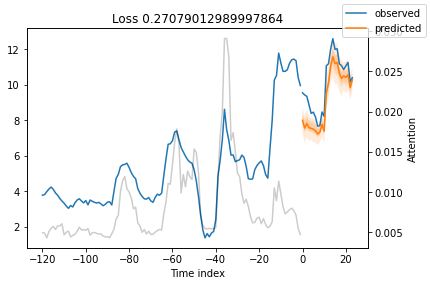

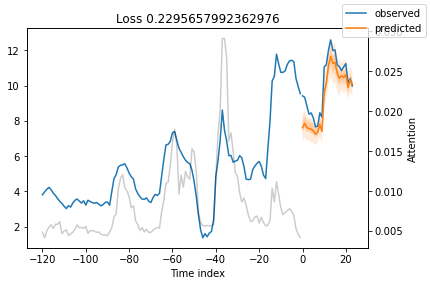

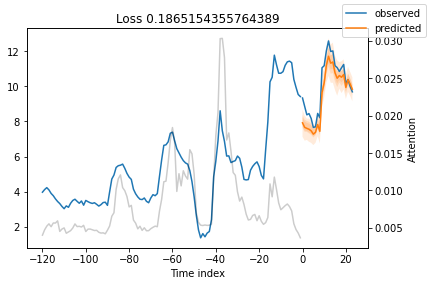

In [37]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Worst performers

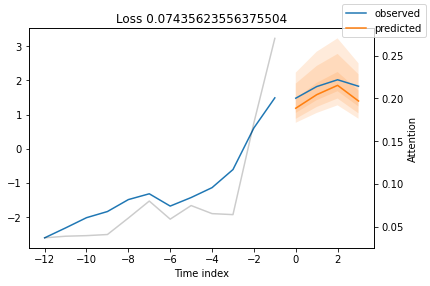

In [26]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variables

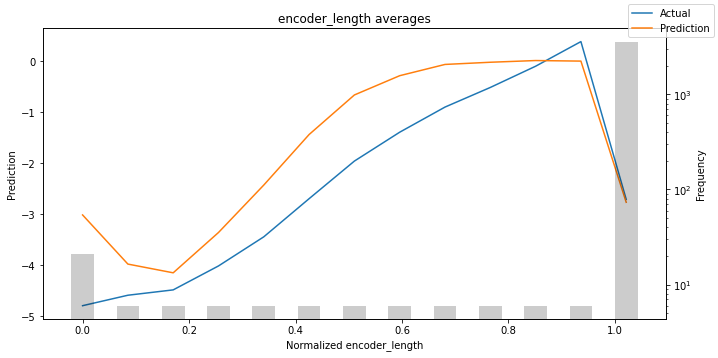

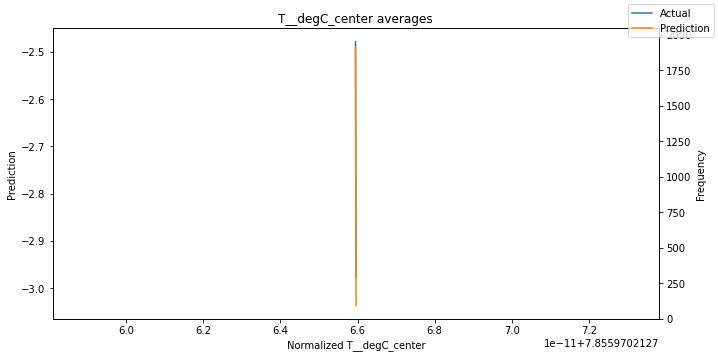

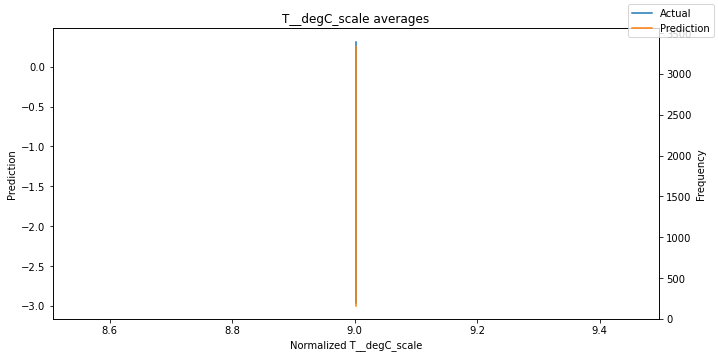

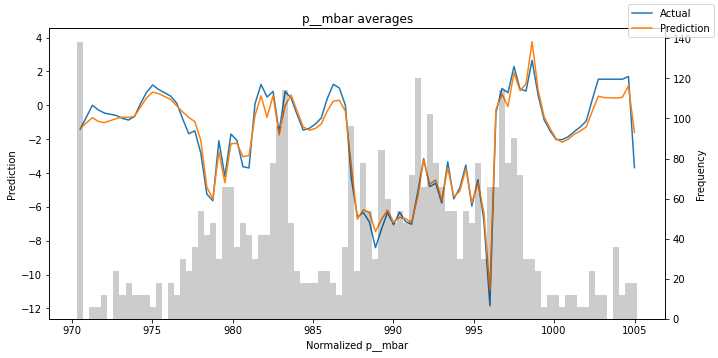

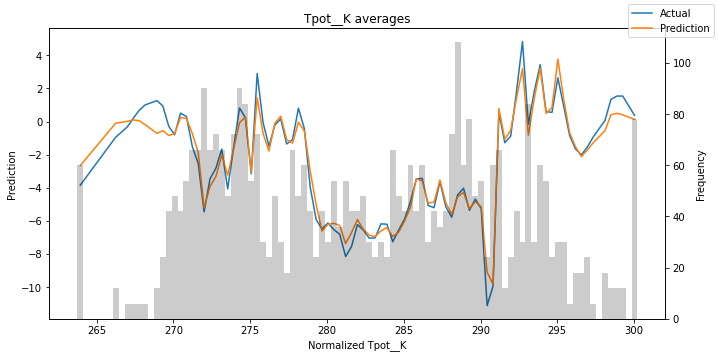

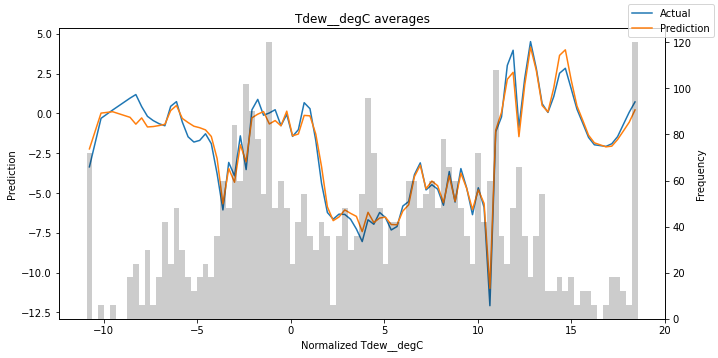

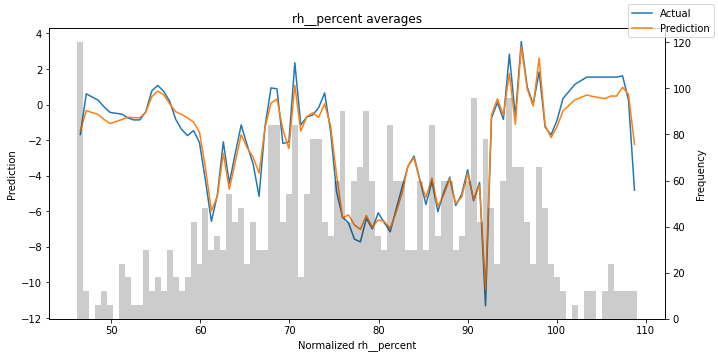

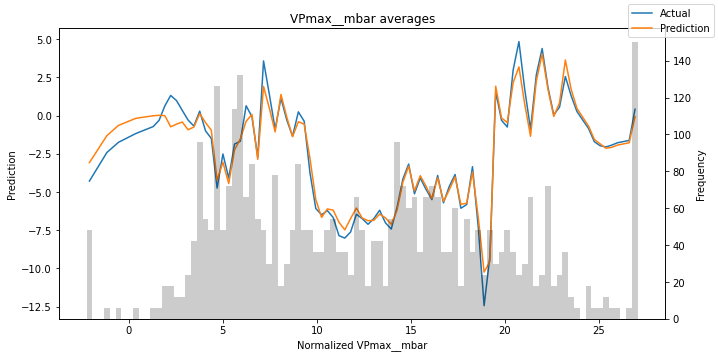

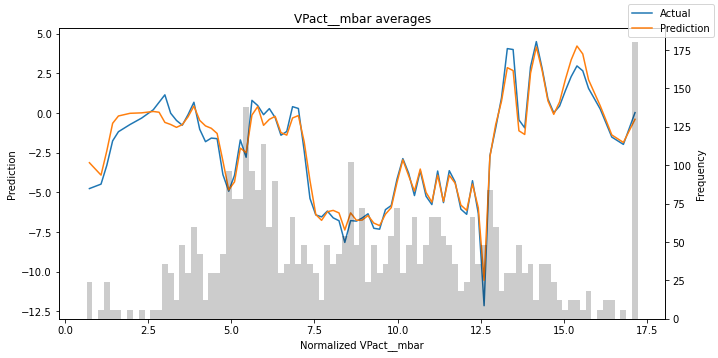

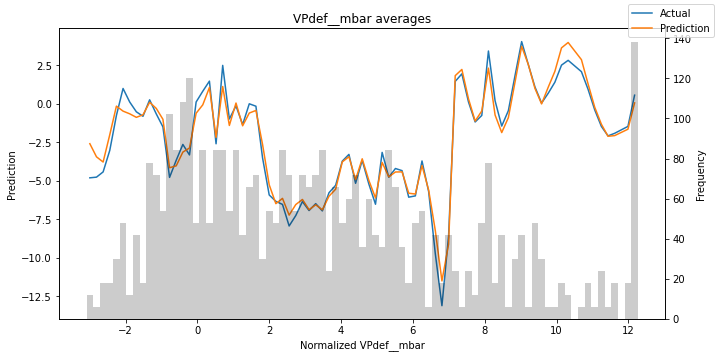

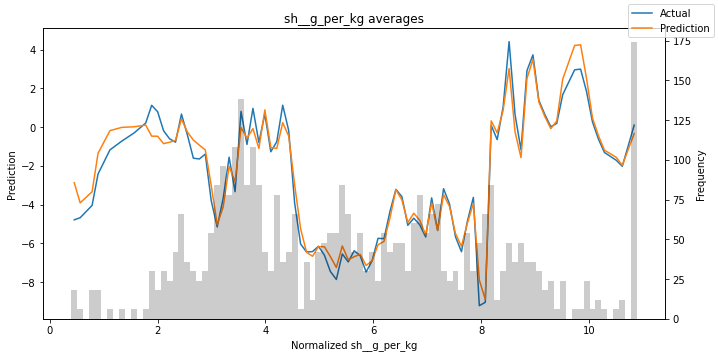

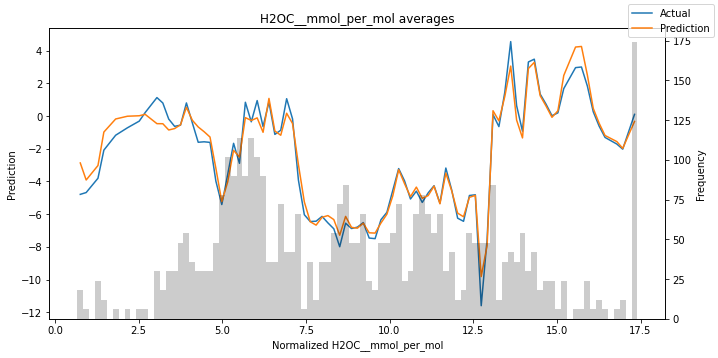

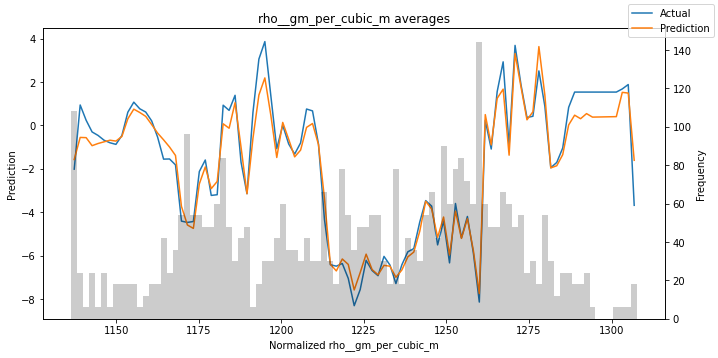

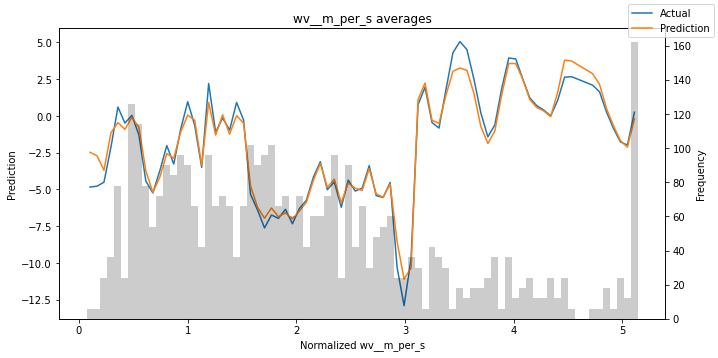

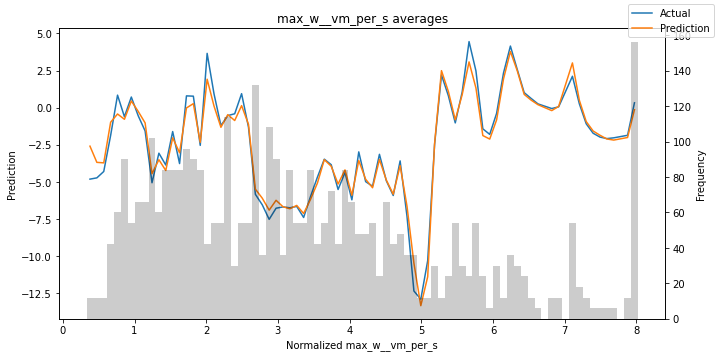

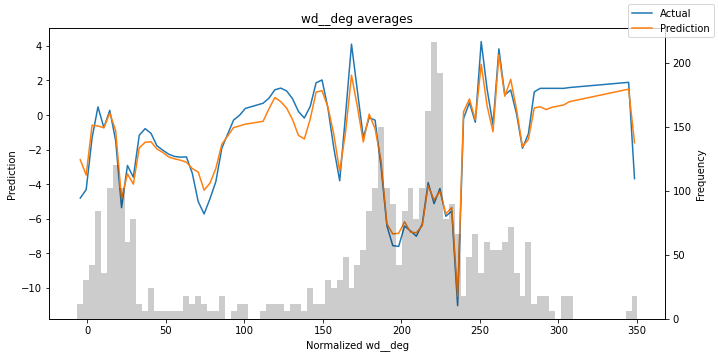

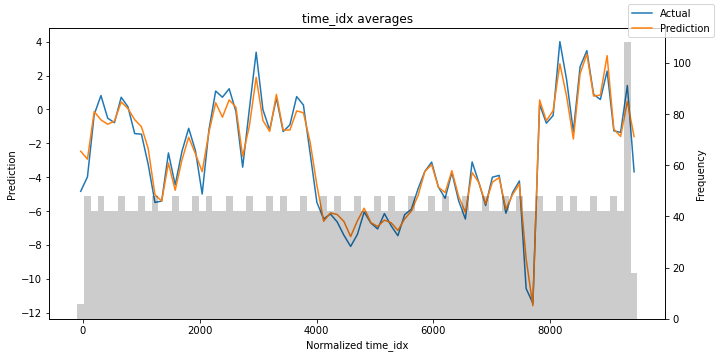

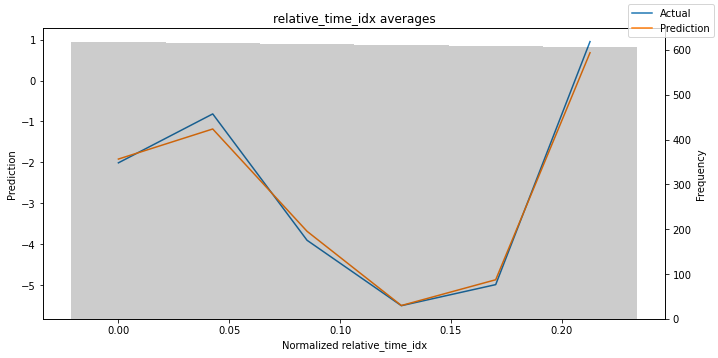

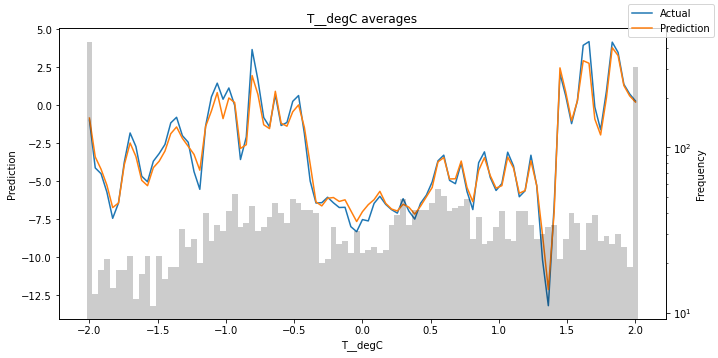

In [25]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Interpret model

### Variable importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x432 with 1 Axes>,
 'decoder_variables': <Figure size 504x414 with 1 Axes>}

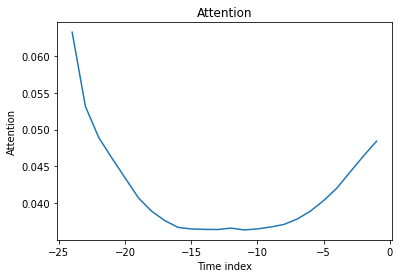

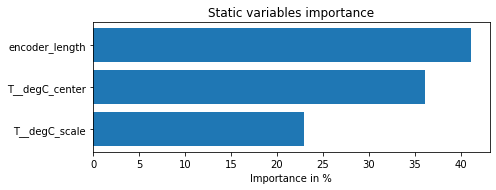

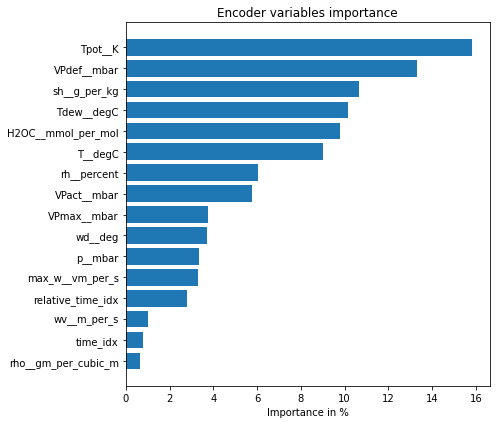

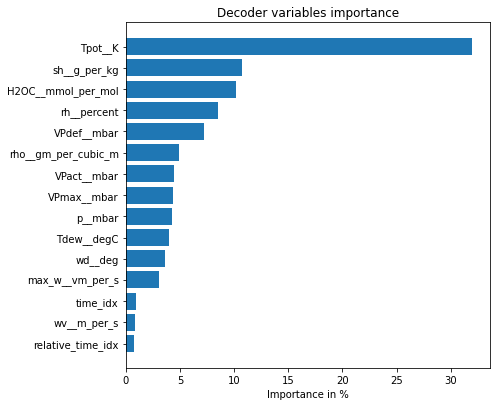

In [18]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.

### Partial dependency

In [19]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "VPact__mbar", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

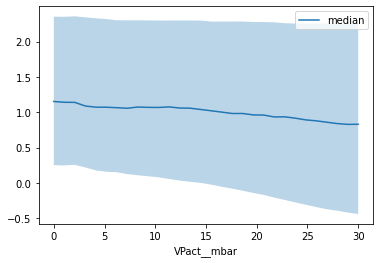

In [20]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("VPact__mbar").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

In [21]:
!pwd

/home/jupyter
